## Multi-label classification

In [1]:
%reload_ext autoreload
%autoreload 2
#%matplotlib inline

In [2]:
from fastai.conv_learner import *

In [3]:
PATH = 'data/planet/'

In [10]:
# Data preparation steps if you are using Crestle:

os.makedirs('data/planet/models', exist_ok=True)
os.makedirs('/cache/planet/tmp', exist_ok=True)

!ln -s /datasets/kaggle/planet-understanding-the-amazon-from-space/train-jpg {PATH}
!ln -s /datasets/kaggle/planet-understanding-the-amazon-from-space/train_v2.csv {PATH}
!ln -s /cache/planet/tmp {PATH}

PermissionError: [Errno 13] Permission denied: '/cachd'

In [4]:
ls {PATH}

models/                   test-jpg-additional/      tmp/           train_v2.csv
sample_submission_v2.csv  test-tif-v2/              train-jpg/
test-jpg/                 test_v2_file_mapping.csv  train-tif-v2/


## Multi-label versus single-label classification

In [5]:
from fastai.plots import *

In [6]:
def get_1st(path): return glob(f'{path}/*.*')[0]

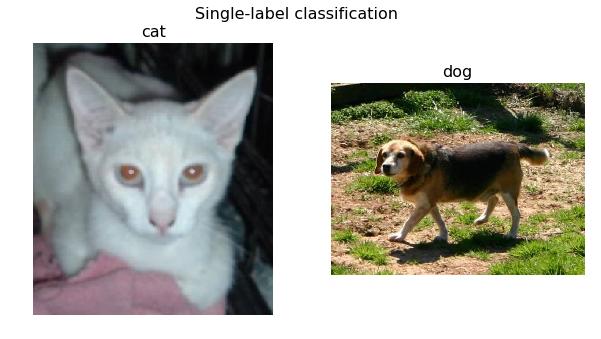

In [7]:
dc_path = "data/dogscats/valid/"
list_paths = [get_1st(f"{dc_path}cats"), get_1st(f"{dc_path}dogs")]
plots_from_files(list_paths, titles=["cat", "dog"], maintitle="Single-label classification")

In single-label classification each sample belongs to one class. In the previous example, each image is either a *dog* or a *cat*.

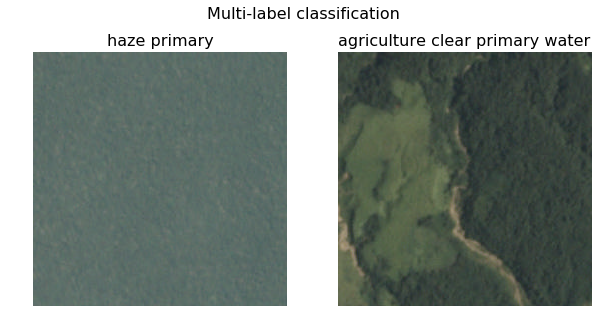

In [9]:
list_paths = [f"{PATH}train-jpg/train_0.jpg", f"{PATH}train-jpg/train_1.jpg"]
titles=["haze primary", "agriculture clear primary water"]
plots_from_files(list_paths, titles=titles, maintitle="Multi-label classification")

In multi-label classification each sample can belong to one or more clases. In the previous example, the first images belongs to two clases: *haze* and *primary*. The second image belongs to four clases: *agriculture*, *clear*, *primary* and  *water*.

## Multi-label models for Planet dataset

In [10]:
from planet import f2

metrics=[f2]
f_model = resnet34

In [11]:
label_csv = f'{PATH}train_v2.csv'
n = len(list(open(label_csv)))-1
val_idxs = get_cv_idxs(n)

We use a different set of data augmentations for this dataset - we also allow vertical flips, since we don't expect vertical orientation of satellite images to change our classifications.

In [12]:
def get_data(sz):
    tfms = tfms_from_model(f_model, sz, aug_tfms=transforms_top_down, max_zoom=1.05)
    return ImageClassifierData.from_csv(PATH, 'train-jpg', label_csv, tfms=tfms,
                    suffix='.jpg', val_idxs=val_idxs, test_name='test-jpg')

In [13]:
data = get_data(256)

In [14]:
x,y = next(iter(data.val_dl))

In [15]:
y


    1     0     0  ...      0     0     1
    0     0     0  ...      0     0     0
    1     0     0  ...      0     0     0
       ...          ⋱          ...       
    1     0     0  ...      0     0     1
    0     0     0  ...      0     0     0
    0     0     0  ...      0     0     1
[torch.cuda.FloatTensor of size 64x17 (GPU 0)]

In [16]:
list(zip(data.classes, y[0]))

[('agriculture', 1.0),
 ('artisinal_mine', 0.0),
 ('bare_ground', 0.0),
 ('blooming', 0.0),
 ('blow_down', 0.0),
 ('clear', 1.0),
 ('cloudy', 0.0),
 ('conventional_mine', 0.0),
 ('cultivation', 0.0),
 ('habitation', 0.0),
 ('haze', 0.0),
 ('partly_cloudy', 0.0),
 ('primary', 1.0),
 ('road', 0.0),
 ('selective_logging', 0.0),
 ('slash_burn', 0.0),
 ('water', 1.0)]

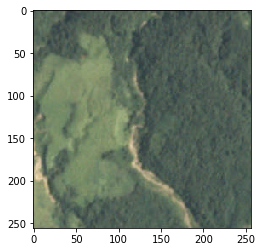

In [17]:
plt.imshow(data.val_ds.denorm(to_np(x))[0]*1.4);

In [18]:
sz=64

In [19]:
data = get_data(sz)

In [20]:
data = data.resize(int(sz*1.3), 'tmp') # dont use any images larger than 1.3* sz, go thru once and create imgs of this new size

HBox(children=(IntProgress(value=0, max=6), HTML(value='')))

In [21]:
learn = ConvLearner.pretrained(f_model, data, metrics=metrics)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss   f2         
    0      0.229982   0.470423   0.732541  



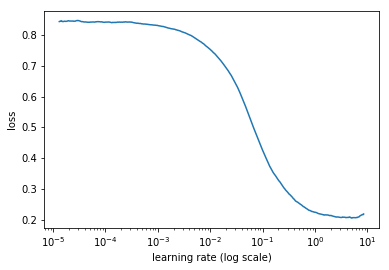

In [22]:
lrf=learn.lr_find()
learn.sched.plot()

In [23]:
lr = 0.2

In [24]:
%time learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   f2         
    0      0.146918   0.134109   0.882713  
    1      0.142392   0.128232   0.889949  
    2      0.132863   0.127118   0.889109  
    3      0.140289   0.127768   0.887192  
    4      0.133313   0.124066   0.893557  
    5      0.133954   0.122453   0.894652  
    6      0.133072   0.122539   0.894119  

CPU times: user 2min 55s, sys: 34.5 s, total: 3min 30s
Wall time: 1min 47s


[0.12253889, 0.89411884692929]

In [25]:
lrs = np.array([lr/9,lr/3,lr])

In [26]:
learn.unfreeze()
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   f2         
    0      0.121278   0.110649   0.90651   
    1      0.119308   0.106216   0.910469  
    2      0.109837   0.102008   0.915555  
    3      0.11053    0.103694   0.914098  
    4      0.103189   0.100993   0.915869  
    5      0.101805   0.099033   0.916984  
    6      0.097365   0.098395   0.91733   



[0.09839456, 0.9173297065826593]

In [27]:
learn.save(f'{sz}')

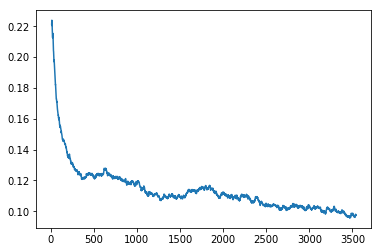

In [28]:
learn.sched.plot_loss()

In [29]:
sz=128

In [30]:
learn.set_data(get_data(sz))
learn.freeze()
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   f2         
    0      0.101595   0.095544   0.917585  
    1      0.098154   0.093983   0.920477  
    2      0.097881   0.093667   0.920358  
    3      0.099741   0.092971   0.922707  
    4      0.094808   0.09282    0.921366  
    5      0.093828   0.09221    0.921973  
    6      0.092859   0.09189    0.923071  



[0.09188993, 0.9230706696784654]

In [31]:
learn.unfreeze()
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)
learn.save(f'{sz}')

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   f2         
    0      0.092927   0.088137   0.927151  
    1      0.095541   0.088415   0.926112  
    2      0.090227   0.086136   0.928463  
    3      0.094773   0.088011   0.927544  
    4      0.09042    0.085867   0.928838  
    5      0.08498    0.085279   0.928279  
    6      0.084632   0.084593   0.928894  



In [32]:
sz=256

In [33]:
learn.set_data(get_data(sz))
learn.freeze()
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   f2         
    0      0.088615   0.089613   0.92425   
    1      0.09202    0.088925   0.924637  
    2      0.090392   0.08835    0.926139  
    3      0.090484   0.088697   0.924447  
    4      0.088989   0.087732   0.926693  
    5      0.088943   0.087509   0.926146  
    6      0.086248   0.087652   0.926053  



[0.08765152, 0.9260525112038722]

In [34]:
learn.unfreeze()
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)
learn.save(f'{sz}')

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   f2         
    0      0.086522   0.083317   0.931103  
    1      0.08915    0.084269   0.930395  
    2      0.08294    0.082111   0.932127  
    3      0.088661   0.084788   0.929715  
    4      0.084678   0.083083   0.93154   
    5      0.080569   0.082325   0.931862  
    6      0.079892   0.081587   0.932671  



In [35]:
multi_preds, y = learn.TTA()
preds = np.mean(multi_preds, 0)

In [36]:
f2(preds,y)

0.9315772305299919

### End